<a href="https://colab.research.google.com/github/Rohit-Madhesiya/Long-Term-Agentic-Memory-with-LangGraph/blob/main/Baseline_Email_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install dotenv langchain_openai

In [29]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY']=userdata.get('OPENAI_API_KEY')

In [30]:
profile={
    "name":"Rohit",
    "full_name":"Rohit Gupta",
    "user_profile_background":"Assistant Systems Engineer working as a Fresher in TCS"
}

In [31]:
prompt_instructions={
    "triage_rules":{
        "ignore":"Marketing newsletters, spam emails, mass company announcements",
        "notify":"Team member out sick, build system notifications, project status updates",
        "respond":"Direct questions from team members, meeting requests,critical bug reports"
    },
    "agent_instructions":"Use these tools when appropriate to help manage Rohit's tasks efficiently"
}

Sample Example

In [32]:
email={
    "from":"Rahul <rahul@tcs.com>",
    "to":"Rohit Gupta <guptarohit@tcs.com",
    "subject":"Quick question about API documentation",
    "body":"""
    Hi Rohit,
    I was reviewing the API documentations for the new authentication service and noticed a few endpoints seem to be missing from the specs.
    Could you help clarify if this was intentional or if we should update the docs?

    Specifically, I am looking at:
    - /auth/login
    - /auth/validate

    Thanks!
    Rahul
    """
}

In [33]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [34]:
llm=init_chat_model("openai:gpt-4o-mini")

In [35]:
class Router(BaseModel):
  """
  Analyze the unread email and route it according to its content
  """
  reasoning:str=Field(
      description="Step-by-step reasoning behind the classification"
  )
  classification:Literal["ignore","respond","notify"]=Field(
      description="The classification of an email: 'ignore' for irrevelant emails, "
      "'notify' for important information that doesn't nees a response, "
      "'respond' for emails that need a reply",
  )


In [36]:
llm_router=llm.with_structured_output(Router)

In [37]:
from langchain.prompts import PromptTemplate


system_prompt=PromptTemplate(
    input_variables=["profile","prompt_instructions"],
    template="Your system message template here, using {profile} and {prompt_instructions}"
)
user_prompt=PromptTemplate(
    input_variables=['email'],
    template="Your user message template here, using {email}"
)

In [38]:
result=llm_router.invoke(
    [
        {'role':"system",'content':system_prompt.format(profile=profile,prompt_instructions=prompt_instructions)},
        {'role':"user",'content':user_prompt.format(email=email)}
    ]
)

In [39]:
print(result)

reasoning='The email from Rahul is a direct question regarding the API documentation, specifically asking for clarification about some missing endpoints. This falls under the category of emails that require a response, as it pertains to an inquiry that needs a detailed answer from Rohit.' classification='respond'


Main Agent, **Tools**

In [40]:
from langchain.tools import tool

In [41]:
@tool
def write_email(to:str,sub:str,content:str)->str:
  """Write and send en email"""
  return f"Email sent to {to} with subject '{subject}'"

In [42]:
@tool
def schedule_meeting(attendees:str,sub:str,duration:int,day:str)->str:
  """Schedule a calendar meeting"""
  return f"Meeting '{subject}' scheduled for {day} with {len(attendees)} attendees"

In [43]:
@tool
def check_calendar_availability(day:str)->str:
  """Check calendar availability for a given day"""
  return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

Main Agent, **Prompt**

In [50]:
from langchain.prompts import SystemMessagePromptTemplate, ChatPromptTemplate
def create_prompt(state):
  """
  Creates prompt for the agent, combining the system message with the user messages
  """
  system_message_prompt=SystemMessagePromptTemplate.from_template(
      "Your system message template here, using {profile} and {prompt_instructions}"
  )

  system_message=system_message_prompt.format(
      profile=profile,
      prompt_instructions=prompt_instructions
  ).content

  prompt=[{
      "role":"system",
      "content":system_message
  }]+state['messages']

  return prompt

In [45]:
!pip install langgraph

In [46]:
from langgraph.prebuilt import create_react_agent

In [51]:
tools=[write_email,schedule_meeting,check_calendar_availability]

In [52]:
agent=create_react_agent(
    "openai:gpt-4o",
    tools=tools,
    prompt=create_prompt
)

In [53]:
response=agent.invoke({
    "messages":[{
        "role":"user",
        "content":"WHat is my availability for tuesday?"
    }]
})

In [59]:
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

You are available on Tuesday at 9:00 AM, 2:00 PM, and 4:00 PM.


Overall Agent

In [60]:
!pip install langgraph

In [61]:
from langgraph.graph import add_messages

class State(TypedDict):
  email_input:dict
  messages:Annotated[list,add_messages]

In [62]:
from langgraph.graph import StateGraph,START,END
from langgraph.types import Command
from typing import Literal

In [72]:
def triage_router(state:State)->Command[Literal['response_agent',"__end__"]]:
  author=state['email_input']['author']
  to=state['email_input']['to']
  subject=state['email_input']['subject']
  email_thread=state['email_input']['email_thread']

  system_prompt=PromptTemplate(
    input_variables=["profile","prompt_instructions"],
    template="Your system message template here, using {profile} and {prompt_instructions}"
  )
  email_input={
      author:author,
      to:to,
      subject:subject,
      email_thread:email_thread
  }
  user_prompt=PromptTemplate(
    input_variables=['email'],
    template="Your user message template here, using {email}"
  )

  result=llm_router.invoke(
    [
        {'role':"system",'content':system_prompt.format(profile=profile,prompt_instructions=prompt_instructions)},
        {'role':"user",'content':user_prompt.format(email=email_input)}
    ]
  )

  if result.classification=='respond':
    print("📧 Classification: RESPOND - This email requires a response")
    goto ="response_agent"
    update={
        "messages":[{
            "role":"user",
            "content":f"Respond to the email {state['email_input']}"
        }]
    }
  elif result.classification=='ignore':
    print("🚫 Classification: IGNORE - This email can be safely ignored")
    update=None
    goto=END
  elif result.classification=='notify':
    print("🔔 Classification: NOTIFY - This email contains important information")
    update=None
    goto=END
  else:
    raise ValueError(f"Invalid classification: {result.classification}")

  return Command(goto=goto,update=update)


In [73]:
email_agent=StateGraph(State)
email_agent=email_agent.add_node(triage_router)
email_agent=email_agent.add_node("response_agent",agent)
email_agent=email_agent.add_edge(START,"triage_router")
email_agent=email_agent.compile()

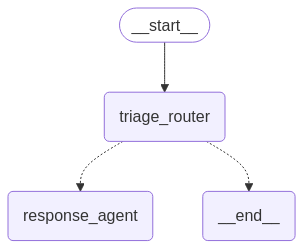

In [74]:
email_agent

In [75]:
email_input={
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "Rohit Gupta <guptarohit@tcs.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "email_thread": """Dear Valued Developer,

Don't miss out on this INCREDIBLE opportunity!

🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite!

✨ FEATURES:
- Revolutionary AI-powered code completion
- Cloud-based development environment
- 24/7 customer support
- And much more!

💰 Regular Price: $999/month
🎉 YOUR SPECIAL PRICE: Just $199/month!

🕒 Hurry! This offer expires in:
24 HOURS ONLY!

Click here to claim your discount: https://amazingdeals.com/special-offer

Best regards,
Marketing Team
---
To unsubscribe, click here
""",
}

In [76]:
response=email_agent.invoke({
    "email_input": email_input
})

🚫 Classification: IGNORE - This email can be safely ignored


In [77]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "Rohit Gupta <guptarohit@tcs.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [78]:
response=email_agent.invoke({
    "email_input": email_input
})

📧 Classification: RESPOND - This email requires a response


In [79]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Rohit Gupta <guptarohit@tcs.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_svptmlhGToCRLt73sP1xcEU4)
 Call ID: call_svptmlhGToCRLt73sP1xcEU4
  Args:
    to: alice.smith@company.com
    sub: RE: Quick question about API documentation
    content: Hi Alice,

Thank you for reaching out and bringing this to my attention. I have noted the concerns regarding the missing endpoints, /